In [4]:
# Plot the list of devices available for TensorFlow

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4992928880730759443
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9218918974
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9425092896408840408
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [7]:
# Set the TensorFlow backend for Keras
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils

import umap

In [9]:
# Loading MNIST digits dataset
from keras.datasets import mnist

In [10]:
# Split the data into training and test sets

%time (X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

Wall time: 297 ms
60000 train samples
10000 test samples


In [11]:
# Fit UMAP model and extract the embedding
reducer = umap.UMAP()

embedding = reducer.fit_transform(X_train)
print(embedding.shape)

(60000, 2)


In [12]:
# Define the neural network model (Using a similar topology to parametric t-SNE)
model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(500, activation='relu'))
model.add(Dense(2000, activation='relu'))
model.add(Dense(2))
%time model.compile(loss='mean_squared_error', optimizer='Adam')

Instructions for updating:
Colocations handled automatically by placer.
Wall time: 31.2 ms


In [14]:
# Fit the training samples
batch_size = 5000
%time model.fit(X_train, embedding, batch_size=batch_size, shuffle=False, epochs=100)
# Predict the embedding for the test samples
%time embedding_test = model.predict(X_test)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
60000/60000 [==============================] - 1s 12us/step - loss: 13.5041
Epoch 2/100
60000/60000 [==============================] - 0s 5us/step - loss: 5.2424
Epoch 3/100
60000/60000 [==============================] - 0s 5us/step - loss: 3.4861
Epoch 4/100
60000/60000 [==============================] - 0s 5us/step - loss: 2.5743
Epoch 5/100
60000/60000 [==============================] - 0s 5us/step - loss: 2.0139
Epoch 6/100
60000/60000 [==============================] - 0s 6us/step - loss: 1.6627
Epoch 7/100
60000/60000 [==============================] - 0s 5us/step - loss: 1.4174
Epoch 8/100
60000/60000 [==============================] - 0s 5us/step - loss: 1.2375
Epoch 9/100
60000/60000 [==============================] - 0s 5us/step - loss: 1.0960
Epoch 10/100
60000/60000 [==============================] - 0s 5us/step - loss: 0.9798
Epoch 11/100
60000/60000 [==============================] - 0s 5us/step - loss: 0.8793
Ep

60000/60000 [==============================] - 0s 5us/step - loss: 0.0549
Epoch 93/100
60000/60000 [==============================] - 0s 5us/step - loss: 0.0550
Epoch 94/100
60000/60000 [==============================] - 0s 5us/step - loss: 0.0564
Epoch 95/100
60000/60000 [==============================] - 0s 5us/step - loss: 0.0579
Epoch 96/100
60000/60000 [==============================] - 0s 5us/step - loss: 0.0605
Epoch 97/100
60000/60000 [==============================] - 0s 6us/step - loss: 0.0642
Epoch 98/100
60000/60000 [==============================] - 0s 6us/step - loss: 0.0682
Epoch 99/100
60000/60000 [==============================] - 0s 5us/step - loss: 0.0716
Epoch 100/100
60000/60000 [==============================] - 0s 4us/step - loss: 0.0752
Wall time: 32 s
Wall time: 162 ms


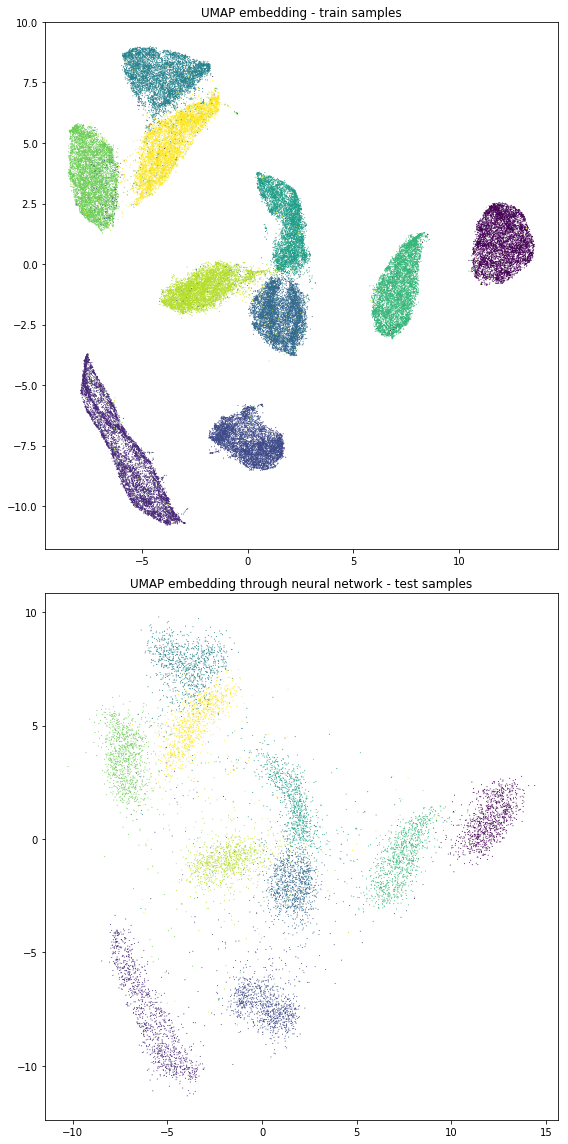

In [16]:
# Plot the embedding for the training and test samples

fig = plt.figure(figsize=(8, 16))
plt.subplot(2, 1, 1)
plt.scatter(embedding[:,0], embedding[:,1], marker='o', s=1, edgecolor='', c=y_train)
plt.title("UMAP embedding - train samples")
plt.subplot(2, 1, 2)
plt.scatter(embedding_test[:,0], embedding_test[:,1], marker='o', s=1, edgecolor='', c=y_test)
plt.title("UMAP embedding through neural network - test samples")
fig.tight_layout()

In [24]:
# Fit a 5-Nearest-neighbor model and predict using the transformed test samples
from sklearn.neighbors import KNeighborsClassifier

mdl = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
%time mdl.fit(embedding, y_train)
%time y_pred = mdl.predict(embedding_test)

Wall time: 19.8 ms
Wall time: 346 ms


In [25]:
from sklearn.metrics import accuracy_score

print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

Accuracy: 0.9286
